In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from function import plot_learning_curve, plot_reg_results_with_diagonal, evaluate_multi_output
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
import xgboost as xgb
import shap
plt.style.use("ggplot")

c:\Users\LL331070\AppData\Local\anaconda3\envs\data_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stable_features_en = pd.read_csv("../date/result_all/en_genes_stability_score.csv", index_col="Feature_Name")
stable_features_rf = pd.read_csv("../date/result_all/rf_genes_stability_score.csv", index_col="Feature_Name")

In [3]:
X_selected_en = stable_features_en.loc[stable_features_en["Stability_Score"] >= 0.8].index.to_list()
X_selected_rf = stable_features_rf.loc[stable_features_rf["Stability_Score"] >= 0.8].index.to_list()
X_selected_genes = list(set(X_selected_en) | set(X_selected_rf))
intersection_genes = list(set(X_selected_en) & set(X_selected_rf))
print(f"Number of selected genes from EN: {len(X_selected_en)}")
print(f"Number of selected genes from RF: {len(X_selected_rf)}")
print(f"Number of selected genes: {len(X_selected_genes)}")
print(f"Number of intersection genes: {len(intersection_genes)}")

Number of selected genes from EN: 226
Number of selected genes from RF: 94
Number of selected genes: 314
Number of intersection genes: 6


In [4]:
for gene in X_selected_genes:
    print(gene)

ENSG00000122378
ENSG00000157514
ENSG00000099139
ENSG00000171488
ENSG00000101057
ENSG00000175471
ENSG00000136574
ENSG00000135842
ENSG00000179750
ENSG00000188613
ENSG00000187957
ENSG00000179046
ENSG00000122641
ENSG00000271738
ENSG00000162949
ENSG00000196358
ENSG00000152268
ENSG00000248690
ENSG00000204941
ENSG00000152778
ENSG00000204335
ENSG00000196812
ENSG00000082512
ENSG00000114948
ENSG00000115267
ENSG00000158856
ENSG00000178752
ENSG00000161544
ENSG00000231925
ENSG00000165507
ENSG00000214049
ENSG00000180155
ENSG00000143512
ENSG00000183914
ENSG00000148680
ENSG00000251247
ENSG00000163485
ENSG00000221887
ENSG00000269600
ENSG00000158023
ENSG00000102109
ENSG00000177459
ENSG00000187231
ENSG00000259498
ENSG00000138646
ENSG00000197565
ENSG00000165912
ENSG00000234614
ENSG00000168118
ENSG00000125820
ENSG00000158373
ENSG00000128040
ENSG00000104081
ENSG00000134323
ENSG00000180660
ENSG00000189369
ENSG00000130475
ENSG00000184545
ENSG00000164093
ENSG00000144407
ENSG00000146678
ENSG00000257261
ENSG0000

In [5]:
X = pd.read_csv("../date/X_y/X_all_preprocess.csv", index_col=0)
X.shape

(513, 6931)

In [6]:
y = np.load("../date/X_y/y_all_preprocess.npy")

In [7]:
X_selected = X[X_selected_genes]
X_selected.shape

(513, 314)

Convertire id

In [8]:
gene_info = pd.read_csv("../date/Info/gene_info.csv", index_col=0)
gene_info

,gene_name,gene_type
gene_id,,
ENSG00000000003,TSPAN6,protein_coding
ENSG00000000005,TNMD,protein_coding
ENSG00000000419,DPM1,protein_coding
ENSG00000000457,SCYL3,protein_coding
ENSG00000000460,C1orf112,protein_coding
...,...,...
ENSG00000288669,AC008763.4,protein_coding
ENSG00000288670,AL592295.6,lncRNA
ENSG00000288671,AC006486.3,protein_coding


In [9]:
gene_list = []
for gene in X_selected.columns:
    if gene in gene_info.index:
        symb = gene_info.loc[gene, "gene_name"]
        gene_list.append(symb)
    else:
        print(f"Gene {gene} not found in gene_info.")

Gene ENSG00000271738 not found in gene_info.
Gene ENSG00000152268 not found in gene_info.
Gene ENSG00000215298 not found in gene_info.
Gene ENSG00000133808 not found in gene_info.
Gene ENSG00000108753 not found in gene_info.
Gene ENSG00000207418 not found in gene_info.


### XGBoost

In [10]:
# Spazio iperparametri
space_xgb = {
    'n_estimators': hp.quniform('n_estimators', 100, 1200, 20),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.3),
    'gamma': hp.uniform('gamma', 0.0, 5.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
    'subsample': hp.uniform('subsample', 0.2, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-8), np.log(10))
}

def objective_xgb(params):
    params_int = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'gamma': params['gamma'],
        'colsample_bytree': params['colsample_bytree'],
        'subsample': params['subsample'],
        'min_child_weight': int(params['min_child_weight']),
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda']
    }
    base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params_int)
    model = MultiOutputRegressor(base)
    r2_scores = cross_val_score(model, X_train_sel, y_train_sel, cv=5, scoring='r2', n_jobs=-1)
    return {'loss': -np.mean(r2_scores), 'status': STATUS_OK}



In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

all_shap0 = []
all_shap1 = []
all_X_tests = []
performance_records = []
feature_names = X_selected.columns.tolist()

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_selected)):
    # Split dati
    X_train_sel, X_test_sel = X_selected.iloc[train_index], X_selected.iloc[test_index]
    y_train_sel, y_test_sel = y[train_index], y[test_index]

    trials_xgb = Trials()
    best_params = fmin(
        fn=objective_xgb,
        space=space_xgb,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_xgb,
        early_stop_fn=no_progress_loss(30),
        rstate=np.random.default_rng(42)
    )

    params_final = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'learning_rate': best_params['learning_rate'],
        'gamma': best_params['gamma'],
        'colsample_bytree': best_params['colsample_bytree'],
        'subsample': best_params['subsample'],
        'min_child_weight': int(best_params['min_child_weight']),
        'reg_alpha': best_params['reg_alpha'],
        'reg_lambda': best_params['reg_lambda']
    }
    base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **params_final)
    model = MultiOutputRegressor(base_model)
    model.fit(X_train_sel, y_train_sel)

    y_pred = model.predict(X_test_sel)
    performance_records.append({
        "fold": fold_idx + 1,
        "R2_Propensity": r2_score(y_test_sel[:, 0], y_pred[:, 0]),
        "R2_Intensity": r2_score(y_test_sel[:, 1], y_pred[:, 1]),
        "MSE_Propensity": mean_squared_error(y_test_sel[:, 0], y_pred[:, 0]),
        "MSE_Intensity": mean_squared_error(y_test_sel[:, 1], y_pred[:, 1])
    })

    print(f"Fold {fold_idx + 1} - R2 Propensity: {performance_records[-1]['R2_Propensity']:.4f}, "
          f"R2 Intensity: {performance_records[-1]['R2_Intensity']:.4f}, "
          f"MSE Propensity: {performance_records[-1]['MSE_Propensity']:.4f}, "
          f"MSE Intensity: {performance_records[-1]['MSE_Intensity']:.4f}")
    
    # Calcolo SHAP 
    expl0 = shap.TreeExplainer(model.estimators_[0])
    expl1 = shap.TreeExplainer(model.estimators_[1])
    sv0 = expl0.shap_values(X_test_sel) 
    sv1 = expl1.shap_values(X_test_sel)
    all_shap0.append(sv0)
    all_shap1.append(sv1)
    all_X_tests.append(X_test_sel)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

 70%|███████   | 70/100 [06:47<02:54,  5.82s/trial, best loss: -0.9417337194529243]
Fold 1 - R2 Propensity: 0.9281, R2 Intensity: 0.9255, MSE Propensity: 0.0005, MSE Intensity: 1.2173
 70%|███████   | 70/100 [06:28<02:46,  5.55s/trial, best loss: -0.9375033425396063]
Fold 2 - R2 Propensity: 0.9692, R2 Intensity: 0.9495, MSE Propensity: 0.0002, MSE Intensity: 0.7308
 70%|███████   | 70/100 [06:15<02:41,  5.37s/trial, best loss: -0.9406667333924517]
Fold 3 - R2 Propensity: 0.9459, R2 Intensity: 0.9590, MSE Propensity: 0.0003, MSE Intensity: 0.5701
 70%|███████   | 70/100 [07:03<03:01,  6.05s/trial, best loss: -0.9357012024207382]
Fold 4 - R2 Propensity: 0.9248, R2 Intensity: 0.9497, MSE Propensity: 0.0004, MSE Intensity: 0.8664
 70%|███████   | 70/100 [07:22<03:09,  6.31s/trial, best loss: -0.9361429339084031]
Fold 5 - R2 Propensity: 0.9739, R2 Intensity: 0.9593, MSE Propensity: 0.0002, MSE Intensity: 0.6394
 70%|███████   | 70/100 [07:20<03:08,  6.29s/trial, best loss: -0.93945940448117

In [12]:
performance_df = pd.DataFrame(performance_records)
print("\nPerformance across folds:")
print(performance_df)


Performance across folds:
   fold  R2_Propensity  R2_Intensity  MSE_Propensity  MSE_Intensity
0     1       0.928093      0.925493        0.000542       1.217256
1     2       0.969221      0.949510        0.000247       0.730834
2     3       0.945895      0.959040        0.000292       0.570086
3     4       0.924836      0.949705        0.000372       0.866379
4     5       0.973867      0.959343        0.000170       0.639428
5     6       0.961419      0.951214        0.000266       0.901273
6     7       0.965186      0.953315        0.000229       0.835903
7     8       0.947611      0.978797        0.000439       0.412769
8     9       0.955855      0.927988        0.000296       1.181208
9    10       0.927090      0.940566        0.000449       0.993942


In [14]:
performance_df.to_csv("../date/result_all/xgb_performance.csv", index=False)

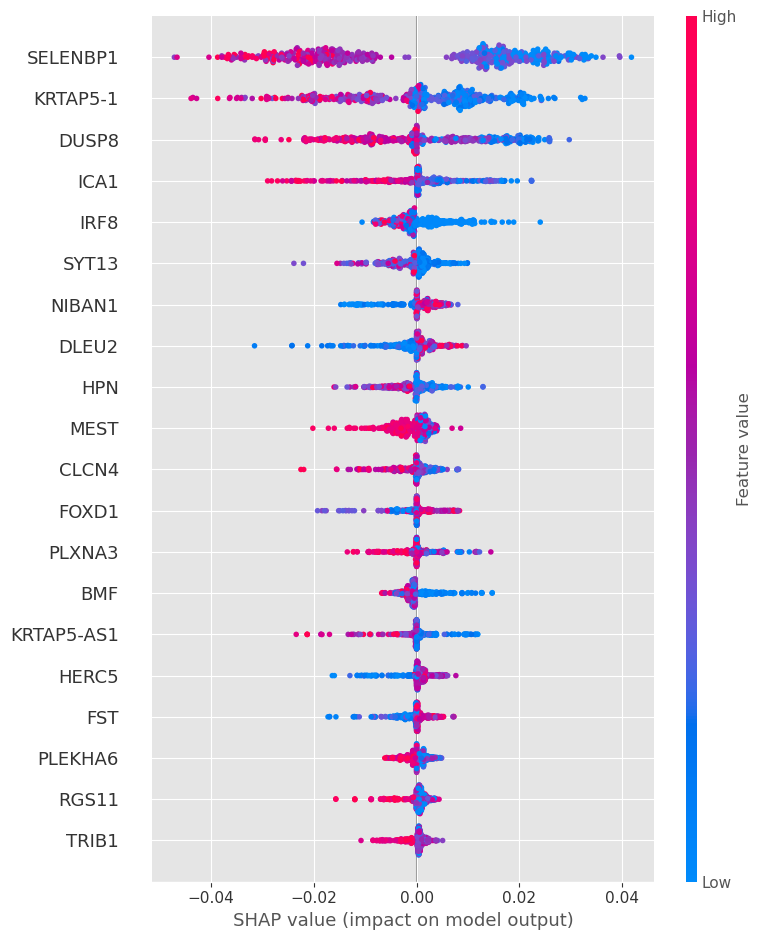

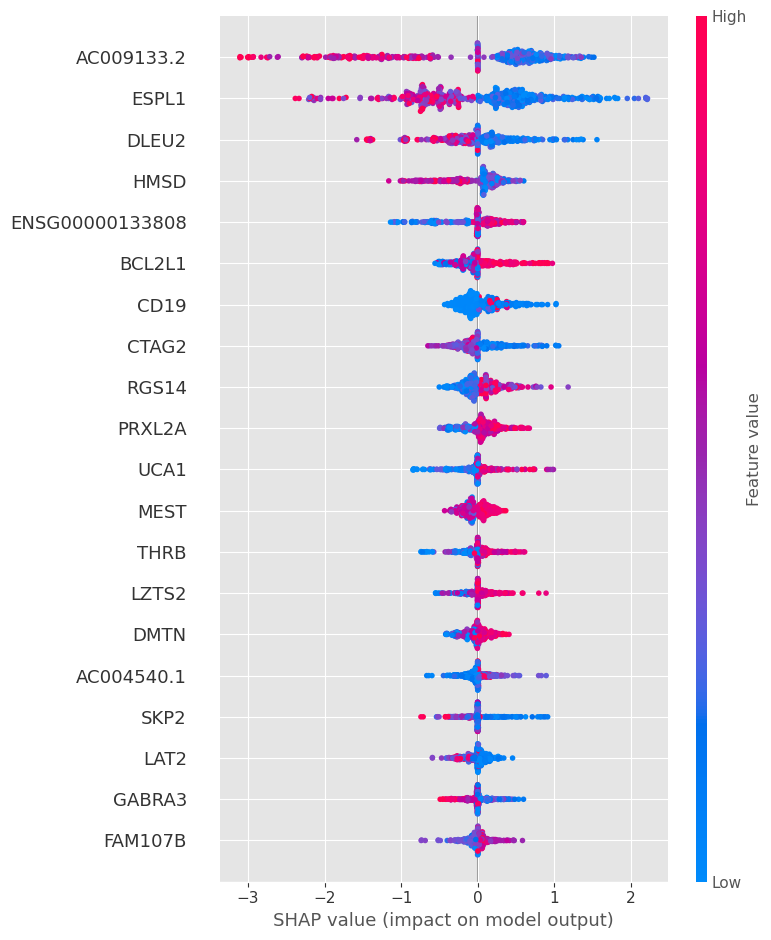

In [13]:
all_shap0 = np.vstack(all_shap0)
all_shap1 = np.vstack(all_shap1)
all_X = pd.concat(all_X_tests, axis=0)

gene_info = pd.read_csv("../date/Info/gene_info.csv", index_col=0)
mapping_dict = dict(zip(gene_info.index, gene_info["gene_name"]))

feature_names_symbols = [mapping_dict.get(gene_id, gene_id) for gene_id in feature_names]

shap.summary_plot(
    all_shap0,
    all_X,
    feature_names=feature_names_symbols,
    plot_type="dot"
)

shap.summary_plot(
    all_shap1,
    all_X,
    feature_names=feature_names_symbols,
    plot_type="dot"
)

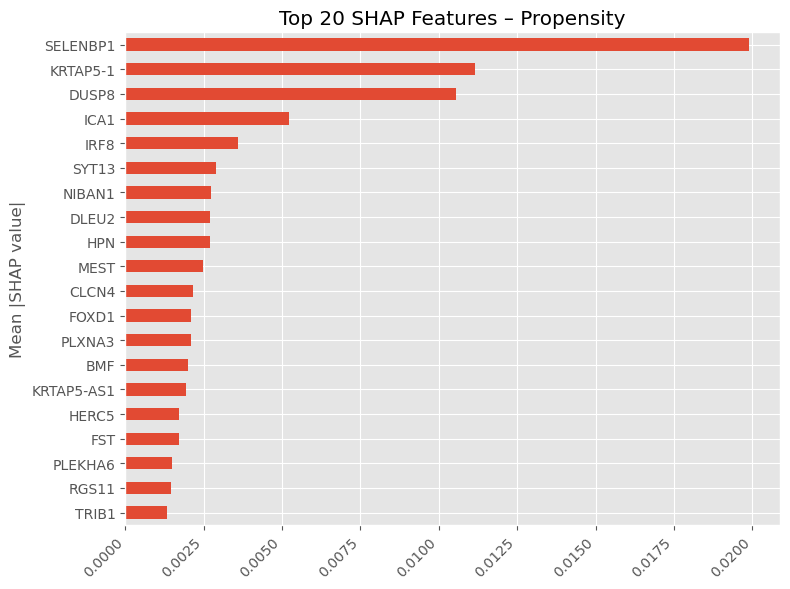

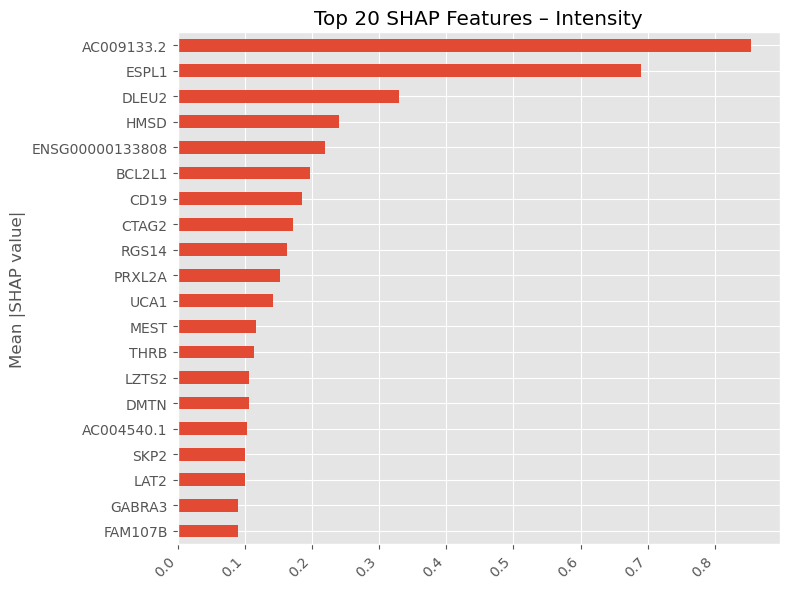

In [15]:
mean_shap0 = np.mean(np.abs(all_shap0), axis=0)  # Propensity
mean_shap1 = np.mean(np.abs(all_shap1), axis=0)  # Intensity

shap_df_propensity = pd.DataFrame(
    mean_shap0,
    index=feature_names_symbols,
    columns=["MeanSHAP_Propensity"]
)

shap_df_intensity = pd.DataFrame(
    mean_shap1,
    index=feature_names_symbols,
    columns=["MeanSHAP_Intensity"]
)

top20_prop = shap_df_propensity.nlargest(20, "MeanSHAP_Propensity")
top20_ints = shap_df_intensity.nlargest(20, "MeanSHAP_Intensity")

plt.figure(figsize=(8, 6))
top20_prop["MeanSHAP_Propensity"].sort_values().plot.barh()
plt.ylabel("Mean |SHAP value|")
plt.title("Top 20 SHAP Features – Propensity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
top20_ints["MeanSHAP_Intensity"].sort_values().plot.barh()
plt.ylabel("Mean |SHAP value|")
plt.title("Top 20 SHAP Features – Intensity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
